In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr, stats
import calendar
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Housekeeping
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family']= 'Times New Roman'
plt.rcParams['axes.facecolor'] = 'black'  
plt.rcParams['figure.facecolor'] = 'black' 
plt.rcParams['text.color'] = 'white'  
plt.rcParams['axes.labelcolor'] = 'white' 
plt.rcParams['xtick.color'] = 'white'  
plt.rcParams['ytick.color'] = 'white'  
plt.rcParams['axes.edgecolor'] = 'white' 
sns.set_style("dark", {"font.family": "Times New Roman",
                        "axes.facecolor": "black",
                       "figure.facecolor": "black",
                       "text.color": "white",
                       "axes.labelcolor": "white",
                       "xtick.color": "white",
                       "ytick.color": "white",
                       "axes.edgecolor": "white"})

In [2]:
data = pd.read_csv('bank.csv')
df = pd.DataFrame(data)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


None

In [3]:
display(df.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# 1. Customer Profiling

General demographic info

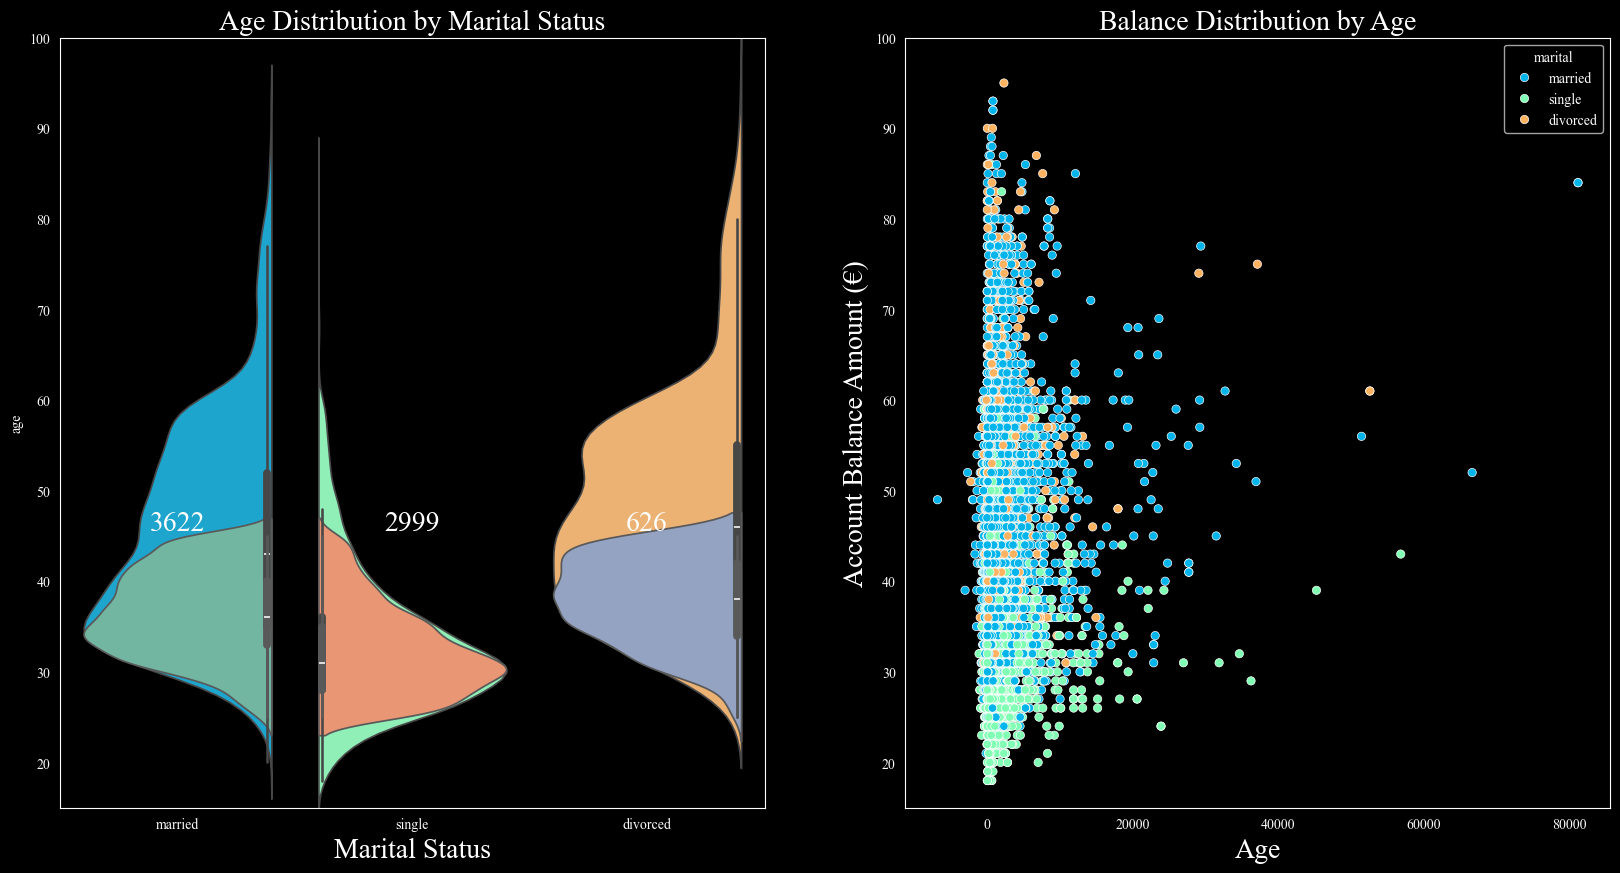

In [4]:
# sns.set_style('whitegrid')

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
# Ploting 1: age distribution by marital status
ax1 = sns.violinplot(x='marital', y='age', data=df, palette='rainbow', split=True, ax=ax1)
highlight = df[(df['age'] >= 25) & (df['age'] <= 45)]
highlight_count = highlight['marital'].value_counts()
ax1 = sns.violinplot(x='marital', y='age', data=highlight, palette='Set2', split=True, ax=ax1)
ax1.set_title('Age Distribution by Marital Status', fontsize=20)
ax1.set_xlabel('Marital Status', fontsize=20)
ax1.set_ylim(15, 100)
for i, marital_status in enumerate(df['marital'].unique()):
    ax1.text(i, 45, s=f'{highlight_count[marital_status]}', ha='center', va='bottom', fontsize=20, color='white')

# Plot 2: Balance distribution by age
ax2 = sns.scatterplot(x='balance', y='age', data=df, hue='marital', palette='rainbow', ax=ax2)
average_balances = df.groupby('marital')['balance'].mean().sort_values(ascending=False)
# for i, (marital_status, avg_balance) in enumerate(average_balances.items()):
    # Annotate the average balance line with the marital status and value
    # ax2.text(df['age'].max(), avg_balance, f'{marital_status} Avg: {avg_balance:.0f}', 
    #          horizontalalignment='right', verticalalignment='center', 
    #          fontsize=15, color=sns.color_palette("Set2")[i])

ax2.set_title('Balance Distribution by Age', fontsize=20)
ax2.set_xlabel('Age', fontsize=20)
ax2.set_ylim(15, 100)
ax2.set_ylabel('Account Balance Amount (€)', fontsize=20)


plt.show()

In [5]:
print(average_balances)

marital
married     1599.927570
single      1457.255259
divorced    1371.835267
Name: balance, dtype: float64


Detailed fianancial health analysis by job

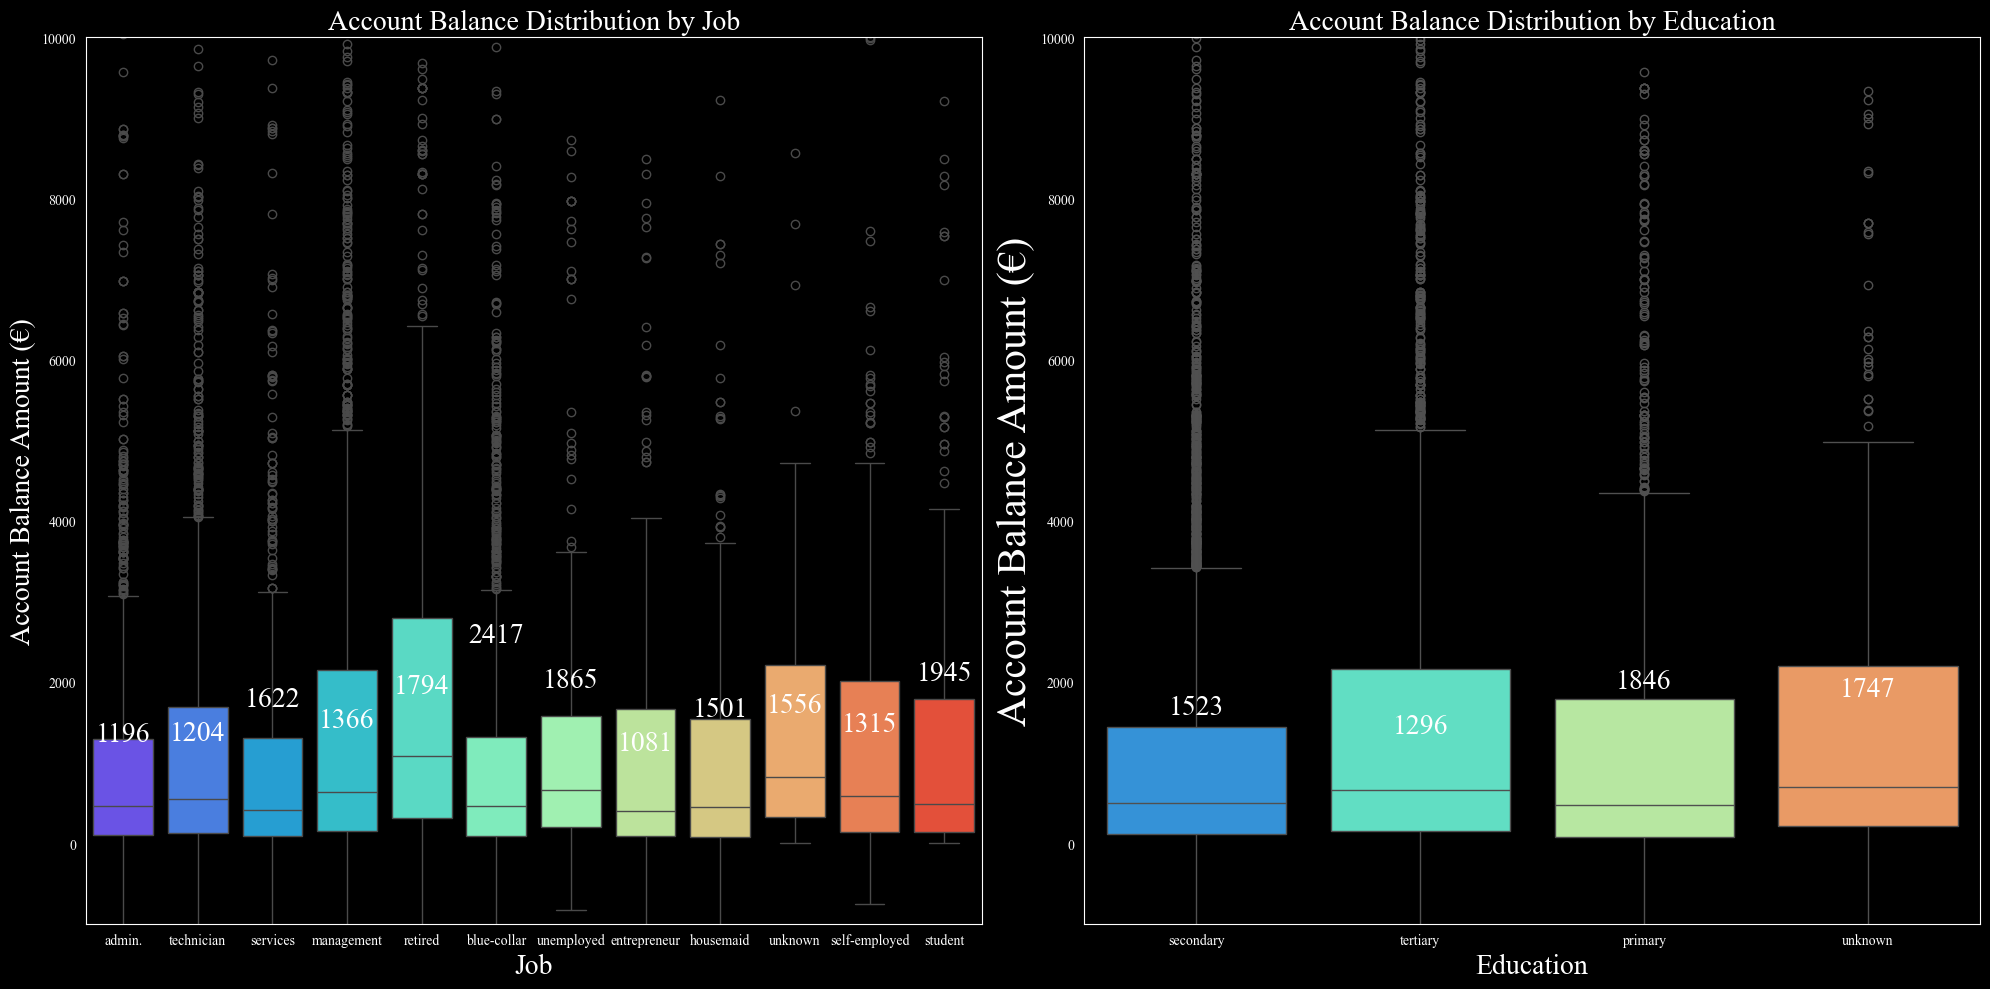

In [6]:
job_mean_balance = df.groupby('job')['balance'].mean().reset_index()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
# Plot 1: Balance distribution by job
ax1 = sns.boxplot(x='job', y='balance', data=df, palette='rainbow', ax=ax1)
for i, (job, mean_balance) in enumerate(job_mean_balance.values.tolist()):
    ax1.text(i, mean_balance, f'{mean_balance:.0f}', ha='center', va='bottom', fontsize=20, color='white')

ax1.set_title('Account Balance Distribution by Job', fontsize=20)
ax1.set_xlabel('Job', fontsize=20)
ax1.set_ylim(-1000, 10000)
ax1.set_ylabel('Account Balance Amount (€)', fontsize=20)

# Plot 2: Balance distribution by education
education_mean_balance = df.groupby('education')['balance'].mean().reset_index()

ax2 = sns.boxplot(x='education', y='balance', data=df, palette='rainbow', ax=ax2)
for i, (education, mean_balance) in enumerate(education_mean_balance.values.tolist()):
    ax2.text(i, mean_balance, f'{mean_balance:.0f}', ha='center', va='bottom', fontsize=20, color='white')
ax2.set_title('Account Balance Distribution by Education', fontsize=20)
ax2.set_xlabel('Education', fontsize=20)
ax2.set_ylim(-1000, 10000)
ax2.set_ylabel('Account Balance Amount (€)', fontsize=30)
plt.tight_layout()
plt.show()


### Hypothesis 1.1: Customers with loans are less likely to opt for term deposit

deposit    no   yes
loan               
no       4897  4805
yes       976   484
Chi2: 135.83
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between those with loan and those without loan


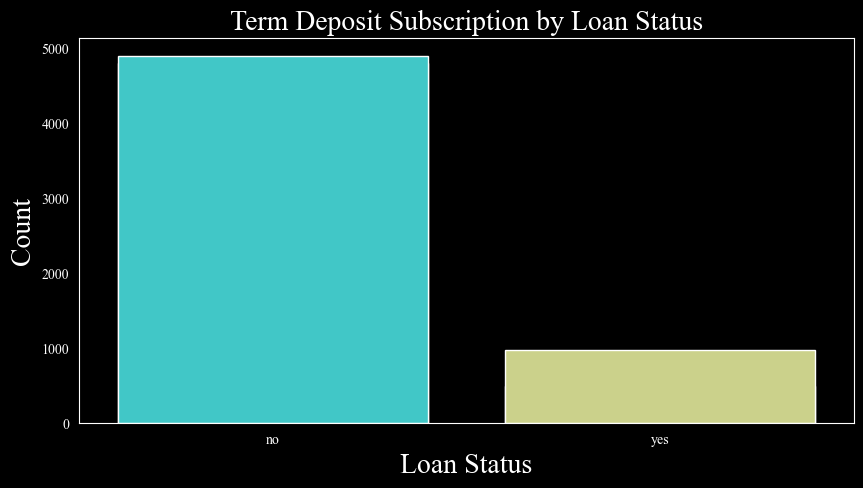

In [7]:
contigency_table = pd.crosstab(df['loan'], df['deposit']) 
print(contigency_table)
chi2, p, dof, expected = chi2_contingency(contigency_table)

plt.figure(figsize=(10, 5))
sns.barplot(x=contigency_table.index, y=contigency_table['yes'], palette='rainbow', label='Yes')
sns.barplot(x=contigency_table.index, y=contigency_table['no'], palette='rainbow', label='No')
plt.title('Term Deposit Subscription by Loan Status', fontsize=20)
plt.xlabel('Loan Status', fontsize=20)
plt.ylabel('Count', fontsize=20)

print(f'Chi2: {chi2:.2f}')
print(f'p-value: {p:.2f}')

alpha = 0.05
if p <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between those with loan and those without loan')
else:
    print('Fail to reject H0')

### Hypothesis 1.2: Lower account balances correlate with lower likelihood of accepting term deposit


Pearson Correlation table

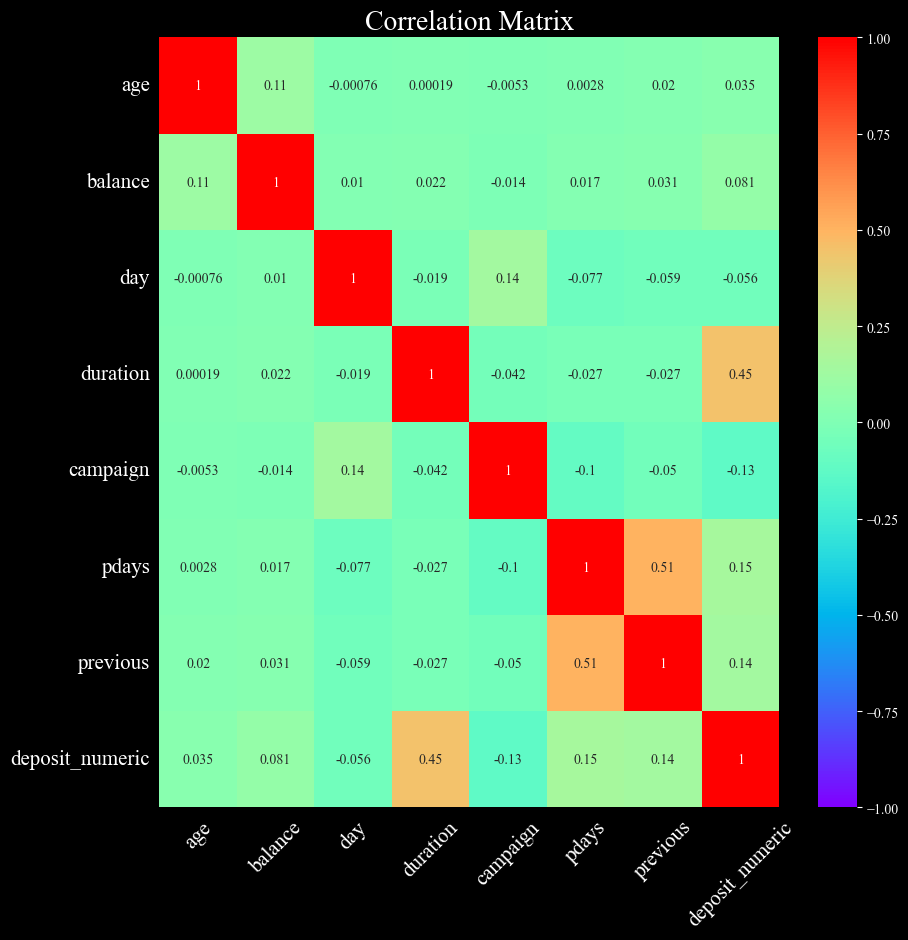

In [8]:
df['deposit_numeric'] = df['deposit'].map({'yes': 1, 'no': 0})

num_df = df[df.select_dtypes(include=np.number).columns]
corr_matrix = num_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='rainbow', vmin=-1, vmax=1)

plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=0,fontsize=15)

plt.show()

Hypothesis testing

In [9]:
print(f'Correlation between account balance and term deposit subscription: {corr_matrix.loc["balance", "deposit_numeric"]:.2f}')
print('Reject hypothesis due to low correlations')

Correlation between account balance and term deposit subscription: 0.08
Reject hypothesis due to low correlations


### Hypothesis 1.3: Younger clients are less likely to enroll to term deposit

# 2. Telemarketing Strategy


### Hypothesis 2.1: Deposit subscription has seasonality

Monthly seasonality

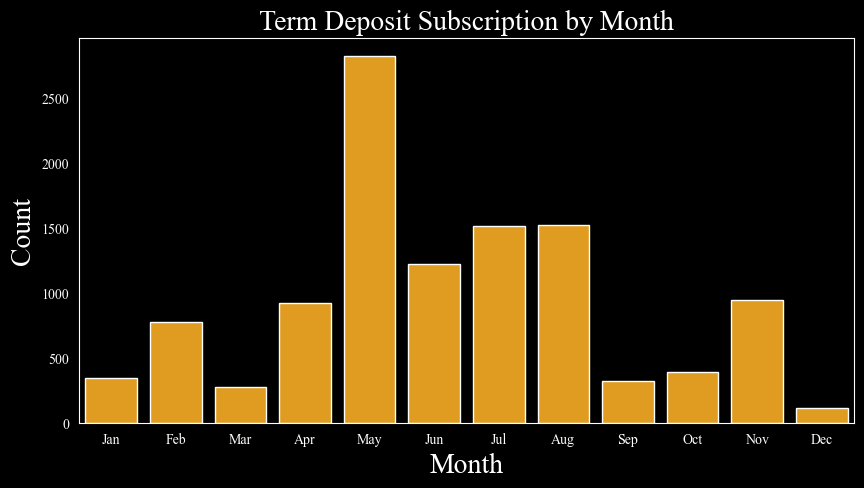

In [10]:
month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# new column with month number
df['month_num'] = df['month'].apply(lambda x: month_order[x.strip().lower()])

# group by month_num and count and average the number of subscriptions
monthly_stats = df.groupby('month_num').agg({'deposit' : ['count']}).reset_index()
monthly_stats.columns = ['month_num', 'deposit_count']

# sort by numerical month
monthly_stats.sort_values(by='month_num', inplace=True)

# Plot
month_names = [calendar.month_abbr[i] for i in monthly_stats['month_num']]
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1 = sns.barplot(x='month_num', y='deposit_count', data=monthly_stats, color='orange')

ax1.set_title('Term Deposit Subscription by Month', fontsize=20)
ax1.set_xticklabels(month_names)
ax1.set_xlabel('Month', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)

plt.show()


In [11]:
# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['month'] == month]['deposit_numeric'] for month in df['month'].unique()])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between months')
else:
    print('Fail to reject H0')

F-value: 104.90
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between months


Day of the month seasonality

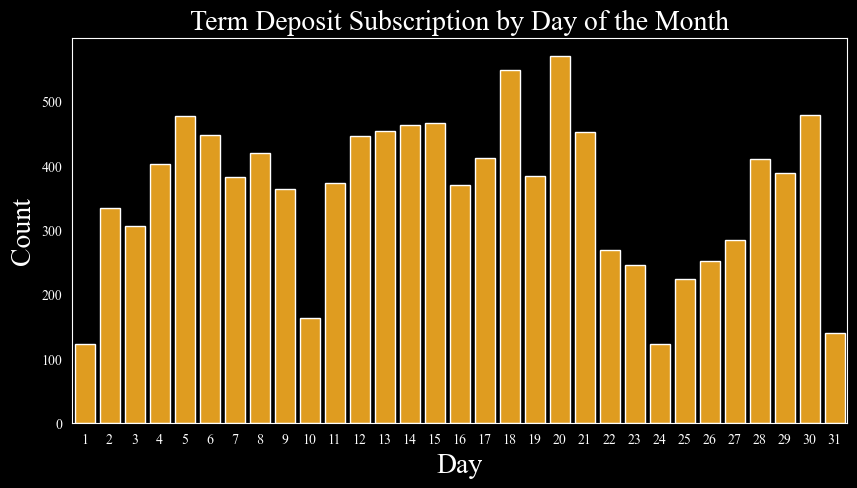

F-value: 12.50
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month


In [12]:
# group by day and count and average the number of subscriptions
daily_stats = df.groupby('day')['deposit_numeric'].agg(['count']).reset_index()
daily_stats.columns = ['day', 'deposit_count']

# sort by day of the month
daily_stats.sort_values(by='day', inplace=True)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1 = sns.barplot(x='day', y='deposit_count', data=daily_stats, color='orange')

ax1.set_title('Term Deposit Subscription by Day of the Month', fontsize=20)
ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)

plt.show()# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['day'] == day]['deposit_numeric'] for day in sorted(df['day'].unique())])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month')
else:
    print('Fail to reject H0')

In [13]:
# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['day'] == day]['deposit_numeric'] for day in sorted(df['day'].unique())])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month')
else:
    print('Fail to reject H0')

F-value: 12.50
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month


### Hypothesis 2.2: The optimal duration of a call

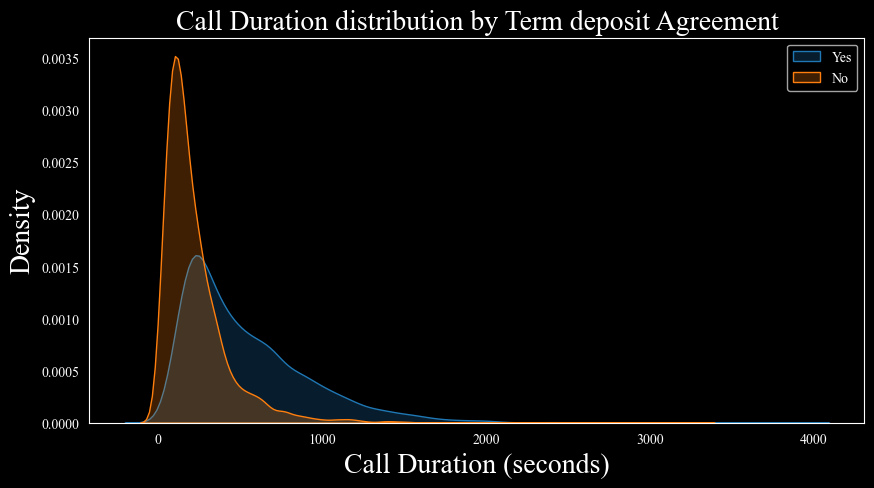

In [14]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['deposit'] == 'yes']['duration'], shade=True, label='Yes')
sns.kdeplot(df[df['deposit'] == 'no']['duration'], shade=True, label='No')
plt.title('Call Duration distribution by Term deposit Agreement', fontsize=20)
plt.xlabel('Call Duration (seconds)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend()
plt.show()

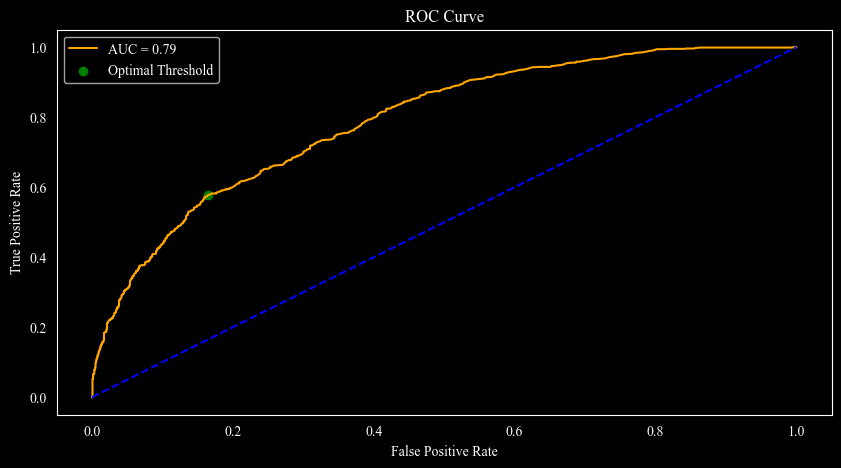

In [15]:
# set up data and model
X_train, X_test, y_train, y_test = train_test_split(df['duration'].values.reshape(-1, 1), df['deposit_numeric'],
                                                    test_size=0.2, random_state=42)
duration_model = LogisticRegression()
duration_model.fit(X_train, y_train)

y_prob = duration_model.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_score = roc_auc_score(y_test, y_prob)

# optimal 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='orange', label=f'AUC = {roc_auc_score:.2f}')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='green', label='Optimal Threshold')
plt.plot([0,1], [0,1], color='blue', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### Hypothesis 2.3: There is a needed break between two campaigns

## 3. Predictive Analysis

Optimal input features and machine learning model that give the best prediction of customer agreeing to term deposit